In [1]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch/")
sys.path.insert(0, "./omegaconf/")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch import nn
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Load Dataset 

In [2]:
TRAIN_ROOT_PATH = f'../Datasets/mpii_human_pose_v1'

train_df = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/train_dataset.csv')
val_df = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/test_dataset.csv')

# wgf 

In [3]:
import numpy as np


def bb_intersection_over_union(A, B):
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()
    for t in range(len(boxes)):
        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            b = [int(label), float(score) * weights[t], float(box_part[0]), float(box_part[1]), float(box_part[2]), float(box_part[3])]
            
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse 
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model 
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable  
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0 
    
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()
    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

# Albumentation 

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

# Utils 

In [5]:
def drawPose(img, joints):
    relation = ((0, 1), (1, 2), (2, 6), (3, 4), (4, 5), (3, 6),
               (6, 7), (7, 8), (8, 9), (7, 12), (12, 11), (11, 10),
               (7, 13), (13, 14), (14, 15))
    
    for rel in relation:
        if joints[rel[0]] == [0, 0] or joints[rel[1]] == [0, 0]:
            if joints[rel[0]] == [0, 0] and joints[rel[1]] == [0, 0]: continue
            elif joints[rel[0]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[1]][0]), int(joints[rel[1]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            elif joints[rel[1]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[0]][0]), int(joints[rel[0]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            else: print("Drawing Error")
        
        else:
            start = (int(joints[rel[0]][0]), int(joints[rel[0]][1]))
            end = (int(joints[rel[1]][0]), int(joints[rel[1]][1]))
            color = (int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]))
            # print(start, end, color)
            cv2.line(img, start, end,
                     color=color,
                     thickness=5)   
    return img


def drawHead(img, head):
    if 0 in head: return img
    
    start = (head[0], head[1])
    end = (head[2], head[3])
    cv2.rectangle(img, start, end, color=(255, 0, 0), thickness=5)
    return img

def drawAll(img, joints, head):
    img = drawPose(img, joints)
    img = drawHead(img, head)
    return img

# Dataloader 

In [6]:
TRAIN_ROOT_PATH = f'../Datasets/mpii_human_pose_v1'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes = self.load_image_and_boxes(index)
        # there is only one class
        try:
            labels = np.array(self.marking['label'][self.marking['name']==image_id])
            labels = torch.as_tensor(labels, dtype=torch.int64)
        except ValueError:
            print(index, image_id)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        
        # print("Log : ", target)
        
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/images/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['name'] == image_id]        
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        return image, boxes


In [7]:
validation_dataset = DatasetRetriever(
    image_ids=val_df['name'],
    marking=val_df,
    transforms=get_valid_transforms(),
    test=True,
)

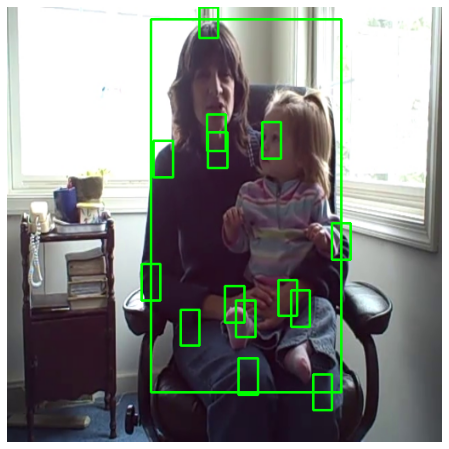

In [8]:
image, target, image_id = validation_dataset[20]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Fitter 

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 20
    n_epochs = 100 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [11]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
import gc

In [12]:
def load_ckpt_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d4')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 17
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_ckpt_net('./effdet4-cutmix-augmix/best-checkpoint-002epoch.bin')

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

In [14]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

[[279 138 291 174]
 [275 114 288 153]
 [200 268 213 305]
 [201 265 213 302]
 [188 387 200 425]
 [276 272 288 297]
 [214 306 227 341]
 [197 433 209 463]
 [293 291 306 326]
 [214 306 227 341]]
[7. 8. 1. 4. 5. 6. 1. 5. 3. 4.]
[0.38297081 0.36144879 0.16905591 0.16864964 0.16802195 0.16467811
 0.15857753 0.15737054 0.15278158 0.15220964]


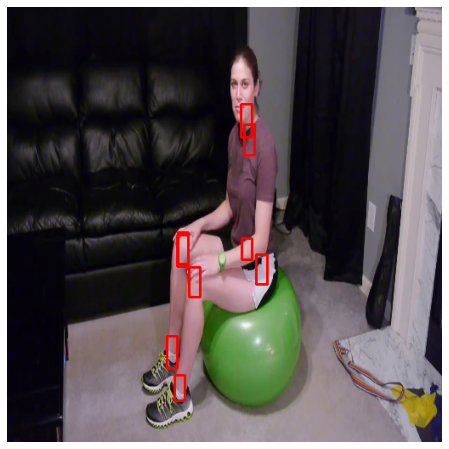

In [21]:
import matplotlib.pyplot as plt
image_idx = 40

for j, (images, _, image_ids) in enumerate(val_loader):
    if j == image_idx: break
        
predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.15)
boxes = boxes.astype(np.int32).clip(min=0, max=512)
print(boxes)
print(labels)
print(scores)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)